# Starting out

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/data.zip .
!unzip -q data.zip
!rm data.zip

!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/test_val.zip .
!unzip -q test_val.zip
!rm test_val.zip

In [3]:
!rm -rf line-chart-captioning/
#clone repo
!git clone https://github.com/snemvalts/line-chart-captioning
#clean out data folder and move extracted raw data to captioning
!rm -rf line-chart-captioning/data/*
!mv data/** line-chart-captioning/data/
!mv test_val/** line-chart-captioning/data/

Cloning into 'line-chart-captioning'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 157 (delta 50), reused 122 (delta 25), pack-reused 0
Receiving objects: 100% (157/157), 232.27 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [4]:
import json


question_types = ["GREATER", "LESS", "INTERSECT"]
synthetic_json = {
  "questions": question_types
}

with open('line-chart-captioning/synthetic.json', 'w') as f:
  json.dump(synthetic_json, f)

In [5]:
!cd line-chart-captioning && git checkout e4f2539aa && \
python3 src/synthetic/preprocess-question-types.py \
--synthetic-config synthetic.json \
data/figureqa/train1

Note: checking out 'e4f2539aa'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at e4f2539 add header column
parsing QA...
parsing annotations...
processing plots...
unrolling descriptions...
copying images...
writing csv...


## creating transforms & dataset

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from skimage import transform


# adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class SyntheticImageDataset(Dataset):
  def __init__(self, csv_file, images_dir, transform=None):
    self.charts_captions = pd.read_csv(csv_file)
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.charts_captions)

  def __getitem__(self, idx):
    [image_number, question_type, color1_name, color2_name, all_subjects] = self.charts_captions.iloc[idx]
    image_path = os.path.join(self.images_dir, f'{str(image_number)}.png')
    image = np.array(Image.open(image_path))
    
    sample = {
        'image': image, 
        'question_type': question_type, 
        'subject1': color1_name, 
        'subject2': color2_name, 
        'all_subjects': all_subjects,    
    }

    if self.transform:
      sample = self.transform(sample)

    return sample

In [7]:
class ResizeImage(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    resized_image = transform.resize(sample['image'], self.output_size)
    return {**sample, 'image': resized_image}

class StripImageTransparency(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    stripped_transparency_image = sample['image'][:,:,:3]
    return {**sample, 'image': stripped_transparency_image}


class NormalizeImage(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, sample):
    normalized_image = (sample['image'] - self.mean) / self.std
    return {**sample, 'image': normalized_image}


class ImageToTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    image = sample['image'].transpose((2, 0, 1))
    return {**sample, 'image': torch.tensor(image).float()}


class QuestionTypeToOneHotTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    #TODO: no flag in preprocessing, this won't work ATM
    question_type = sample['question_type']
    question_type_index = question_types.index(question_type)

    #question_type_onehot = torch.zeros(3)
    #question_type_onehot[question_type_index] = 1

    #question_type_onehot = question_type_onehot.type(torch.LongTensor)
    return {**sample, 'question_type': question_type_index }


# NOT USING ATM
class QuestionSubjectsTransform(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    subject_1 = sample['subject1']
    subject_2 = sample['subject2']

    question_type_index = question_types.index(question_type)

    return {**sample, 'question_type': question_type_index }

#TODO: how do we encapsulate subjects?

In [8]:
import torch

def get_dataset(images_dir = None, csv_file = None):
  # parallely calculate max caption len and word map to pass it to padcaption
  # cause can't access dataset from transforms before it is defined in compose

  dataset = SyntheticImageDataset(images_dir = images_dir,
                           csv_file = csv_file,
                           transform=transforms.Compose([
                                  ResizeImage((112, 112)),
                                  StripImageTransparency(),
                                  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ImageToTensor(),
                                  QuestionTypeToOneHotTensor()
                                 ]))

  return dataset


train_dataset = get_dataset(images_dir = 'line-chart-captioning/data/processed_synthetic/train1-types/images',
                      csv_file = 'line-chart-captioning/data/processed_synthetic/train1-types/captions.csv')


batch_size=64

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)


In [9]:
import torchvision
from torch import nn

class Model(nn.Module):
  def __init__(self, num_classes):
    super(Model, self).__init__()

    base_resnet = torchvision.models.resnet50(pretrained=True) 
    resnet_without_fc = nn.Sequential(*(list(base_resnet.children())[:-1]))
    # freeze weights of resnet 
    for parameter in resnet_without_fc.parameters():
      parameter.requires_grad = False

    self.hidden1 = nn.Linear(2048, 6000)
    self.hidden2 = nn.Linear(6000, 6000)
    self.hidden3 = nn.Linear(6000, 6000)
    self.hidden4 = nn.Linear(6000, 6000)
    self.output = nn.Linear(6000, 112*112*3)
    self.relu = nn.ReLU()

    self.resnet = resnet_without_fc
    #self.pool = nn.AdaptiveAvgPool3d(encoder_shape)

  
  def forward(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).squeeze()
    x = self.relu(self.hidden1(x))
    x = self.relu(self.hidden2(x))
    x = self.relu(self.hidden3(x))
    x = self.relu(self.hidden4(x))
    x = self.output(x)
    x = torch.reshape(x, (batch_size, 112, 112, 3))
    return x

In [10]:
# Own decoder
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import random


torch.cuda.empty_cache()

def accuracy(predictions, target):
  correct = torch.eq(predictions, target).sum()
  total = target.shape[0]
  return (correct/total)*100.0



def train_epoch(iter_cap=50):
  global min_loss

  for i, batch in enumerate(train_loader):
    imgs = batch['image'].to(device)



    decoded_image_scores = model(imgs).permute(0, 3, 1, 2)

    #print(prediction_scores.shape, target_types.shape)
    # Calculate loss
    loss = criterion(decoded_image_scores, imgs)

    model_optimizer.zero_grad()
    loss.backward()
    model_optimizer.step()

    loss_score = loss.cpu().detach().numpy()
    if (loss_score <= min_loss):
      min_loss = loss_score
      iter_without_improvement = 0
    else:
      iter_without_improvement += 1

    accuracy_score = 0#accuracy(predictions, target_types)

    print(f"Batch #{i}/{len(train_loader)}: Loss is {loss_score:.3f}")

    if (iter_without_improvement >= iter_cap):
      print(f"{iter_cap} iterations without improvement. stopping")
      break



encoder_shape = (2048, 3, 3)
hidden_dim = 1024
category_count = len(question_types)

lr = 1e-5
epochs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(num_classes=category_count).to(device)
model_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                                             lr=lr)

criterion = nn.MSELoss().to(device)

min_loss = float('inf')
iter_without_improvement = 0

model.train()

for epoch in range(epochs):
  print(f"Epoch {epoch + 1} of {epochs}")
  train_epoch(iter_cap = 300)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch 1 of 1
Batch #0/717: Loss is 5.589
Batch #1/717: Loss is 5.607
Batch #2/717: Loss is 5.576
Batch #3/717: Loss is 5.580
Batch #4/717: Loss is 5.577
Batch #5/717: Loss is 5.557
Batch #6/717: Loss is 5.541
Batch #7/717: Loss is 5.523
Batch #8/717: Loss is 5.513
Batch #9/717: Loss is 5.473
Batch #10/717: Loss is 5.469
Batch #11/717: Loss is 5.421
Batch #12/717: Loss is 5.385
Batch #13/717: Loss is 5.336
Batch #14/717: Loss is 5.255
Batch #15/717: Loss is 5.196
Batch #16/717: Loss is 5.113
Batch #17/717: Loss is 4.979
Batch #18/717: Loss is 4.850
Batch #19/717: Loss is 4.697
Batch #20/717: Loss is 4.499
Batch #21/717: Loss is 4.301
Batch #22/717: Loss is 4.037
Batch #23/717: Loss is 3.740
Batch #24/717: Loss is 3.430
Batch #25/717: Loss is 3.046
Batch #26/717: Loss is 2.636
Batch #27/717: Loss is 2.219
Batch #28/717: Loss is 1.815
Batch #29/717: Loss is 1.392
Batch #30/717: Loss is 1.032
Batch #31/717: Loss is 0.804
Batch #32/717: Loss is 0.786
Batch #33/717: Loss is 0.900
Batch #34/

KeyboardInterrupt: ignored

In [11]:
batch = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 112, 112])
0.16876593
0.31574345


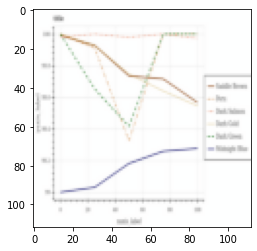

In [22]:
import matplotlib.pyplot as plt

imgs = batch['image'].to(device)
reconstructed_imgs = model(imgs)

reconstructed_imgs[0]

print(imgs[0].shape)
first_base_img_numpy = imgs[0].permute((1, 2, 0)).cpu().numpy()
first_reconstructed_img_numpy = reconstructed_imgs[0].cpu().detach().numpy()
second_reconstructed_img_numpy = reconstructed_imgs[1].cpu().detach().numpy()
third_reconstructed_img_numpy = reconstructed_imgs[1].cpu().detach().numpy()

print(first_reconstructed_img_numpy.std())
print(first_base_img_numpy.std())


def to_normal(img):
  return (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]


plt.imshow(to_normal(first_base_img_numpy))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


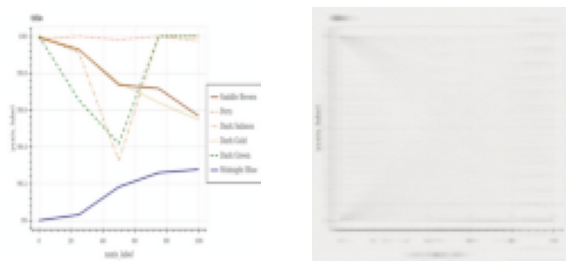

In [61]:

fig, axarr = plt.subplots(1,2) 
fig.set_figheight(5)
fig.set_figwidth(10)
axarr[0].axis('off')
axarr[1].axis('off')

axarr[0].imshow(to_normal(first_base_img_numpy))
axarr[1].imshow(to_normal(first_reconstructed_img_numpy))
#plt.imshow(to_normal(first_reconstructed_img_numpy))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


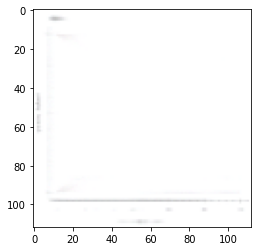

In [24]:
plt.imshow(to_normal(second_reconstructed_img_numpy))

## saving logic

In [ ]:
import datetime
date_str = datetime.datetime.now().replace(microsecond=0).isoformat()

decoder_name = f'decoder_featureattention_{date_str}'
decoder_state_file_name = f'{decoder_name}_state.pth'
decoder_serialized_file_name = f'{decoder_name}_serialized.pth'

torch.save(decoder.state_dict(), decoder_state_file_name)
torch.save(decoder, decoder_serialized_file_name)

In [ ]:
from google.colab import files
files.download(decoder_state_file_name) 
files.download(decoder_serialized_file_name)